In [ ]:
from google.colab import files
from google.colab import drive  
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f77bbdb4-b6e4-be32-88bb-45184cd492d0)


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  1 08:25:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Unzipping train-valid-zip from GDrive to the colab's local storage.

In [ ]:
!unzip "/content/gdrive/MyDrive/dl_reddit/train_set.zip" -d "/content"
!unzip "/content/gdrive/MyDrive/dl_reddit/valid_set.zip" -d "/content"
!unzip "/content/gdrive/MyDrive/dl_reddit/test_set.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/test_set/0/2021.10.16_90.png  
  inflating: /content/test_set/0/2021.10.14_85.png  
  inflating: /content/test_set/0/2021.09.22_93.png  
  inflating: /content/test_set/0/2021.09.13_66.png  
  inflating: /content/test_set/0/2021.09.11_41.png  
  inflating: /content/test_set/0/2021.08.29_124.png  
  inflating: /content/test_set/0/2021.09.14_103.png  
  inflating: /content/test_set/0/2021.10.03_135.png  
  inflating: /content/test_set/0/2021.10.01_118.png  
  inflating: /content/test_set/0/2021.09.22_134.png  
  inflating: /content/test_set/0/2021.09.24_64.png  
  inflating: /content/test_set/0/2021.08.26_117.png  
  inflating: /content/test_set/0/2021.09.05_90.png  
  inflating: /content/test_set/0/2021.09.03_126.png  
  inflating: /content/test_set/0/2021.08.27_40.png  
  inflating: /content/test_set/0/2021.09.29_157.png  
  inflating: /content/test_set/0/2021.09.22_47.png  
  inflating: /content/test_set/0/2021.09

Calculating weigths used for our imbalanced image classification task. There are other methods for dealing with the imbalance such as 
- Undersampling the dominating class => too much information loss 
- Oversampling or any variants of SMOTE => dataset would be even bigger and with the constraints we have with time and gpu resources, it's not possible 

That's why we stick with class weighting. 

Formula for calculating weights for 'balanced' class weights. 
w_j = n_samples / (n_classes * n_samples_j)

In [ ]:
train0_lst_num = !ls "/content/train_set/0" | wc -l
train1_lst_num = !ls "/content/train_set/1" | wc -l

num_train0 = float(train0_lst_num[0])
num_train1 = float(train1_lst_num[0])
num_train = num_train0 + num_train1
n_classes = 2

w0 = num_train/(n_classes * num_train0)  #weight for class 0
w1 = num_train/(n_classes * num_train1)  #weight for class 1 

print('Weight for Class0:', w0)
print('Weight for Class1:', w1)


Weight for Class0: 0.5268318160201101
Weight for Class1: 9.817297040670992


Copying the corresponding csv-s to the local storage


In [ ]:
!cp "/content/gdrive/MyDrive/dl_reddit/train_set.csv" "./"
!cp "/content/gdrive/MyDrive/dl_reddit/valid_set.csv" "./"
!cp "/content/gdrive/MyDrive/dl_reddit/test_set.csv" "./"

# **New format still in Tensorflow**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve, average_precision_score, roc_auc_score, roc_curve

Number of instances in each set. 

In [ ]:
main_dir = '/content/'
subdir_lst = ['train_set', 'valid_set/', 'test_set']

for subdir in subdir_lst:
  total = 0
  for root, dirs, files in os.walk(main_dir + subdir):
    total += len(files)

  print(subdir, '-------', total, 'instances')

train_set ------- 248142 instances
valid_set/ ------- 5000 instances
test_set ------- 5000 instances


Creating tf.data.Dataset from image files in a directory.

In [ ]:
train_dir = '/content/train_set/'
validation_dir = '/content/valid_set/'
test_dir = '/content/test_set/'

BATCH_SIZE = 128
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            color_mode = 'rgb',
                                                            seed = 42,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 color_mode = 'rgb',
                                                                 seed = 42,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           color_mode = 'rgb',
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)



class_names = train_dataset.class_names
print('Class names:', class_names)


Found 248142 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Class names: ['0', '1']


Some pics sample with their label

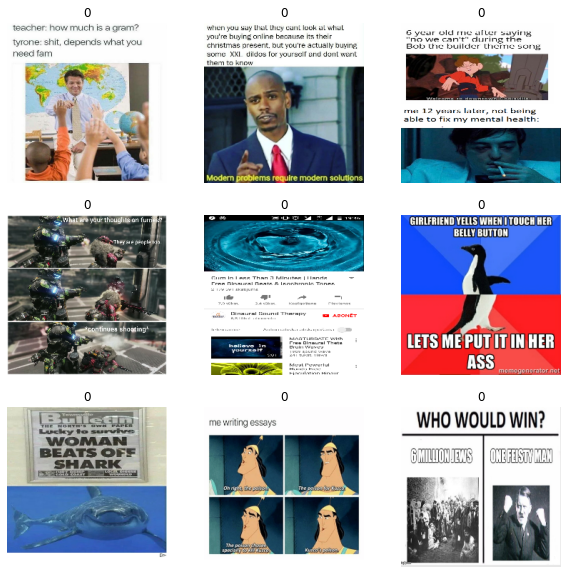

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


Creating a sequence of data agumentation that will be called with the help of Functional API later on. 
Data Augumentation's elements are self-suficcient 

In [ ]:
data_augmentation = tf.keras.Sequential([                              
  tf.keras.layers.RandomContrast(0.3),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomZoom(height_factor=0.3, width_factor=0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2)
])


Demonstrating the result of data-auugumentation on a simple example 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


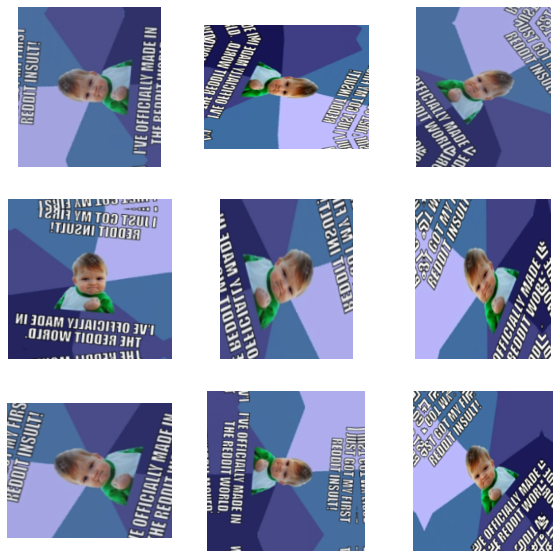

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


Prefatching datasets in order for the training to parallalize the execution of step s and reading the data for step s+1. 

Using cache was also an option but the amount of RAM was not enough. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# RESNET

Removing top layers for us to add the apprpriate top layers for this classification task. Also we used pre-trained imagenet weights. 
At first, we froze the transferred model layers so when learning for the first time those layers will not be adjusted. As it is a binary classification, at the end there will be a single neuron with sigmoid activation. 



In [ ]:
###RESNET152V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

### Using Functional API. With data augumentation incorporated here, gpu will be better deployed. Only augument on train_dataset
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False) # Running in inference mode. That will be important when unfreezing the base_model because batchnorm will not update its batnorm stats.
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_resnet = tf.keras.Model(inputs, outputs)




234561536/234545216 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

Using Adam optimization, binary_crossentropy and weighted accuracy metrics because the imbalance between classes.

In [ ]:
base_learning_rate = 0.001
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = 'binary_crossentropy',
              weighted_metrics=['accuracy'],
              )


In [ ]:
model_resnet.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, None, None, 3)    0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, None, None, 3)    0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

Setting early reduction, learning rate reducer based on val_loss. 
Also saving the best model with checkpointer.  

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

lr_reduc = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                            patience=3,
                            verbose=1,
                            factor=0.2,
                            min_lr=0.00001)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='resnet_best_model_weights_wo_ft.hdf5', save_best_only=True, verbose=1)

callbacks = [checkpointer, early_stopping, lr_reduc]


Adding class weights to our model

In [ ]:
cw={0: w0, 1: w1}
initial_epochs = 15

history_resnet = model_resnet.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset,
                    class_weight = cw,
                    workers = 8,
                    use_multiprocessing = True,
                    callbacks = callbacks)

Epoch 1/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.5697
Epoch 00001: val_loss improved from inf to 0.60372, saving model to resnet_best_model_weights_wo_ft.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1939/1939 [==============================] - 1749s 892ms/step - loss: 0.6831 - accuracy: 0.5697 - val_loss: 0.6037 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 2/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.5890
Epoch 00002: val_loss improved from 0.60372 to 0.58532, saving model to resnet_best_model_weights_wo_ft.hdf5
1939/1939 [==============================] - 1733s 890ms/step - loss: 0.6692 - accuracy: 0.5890 - val_loss: 0.5853 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 3/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.5957
Epoch 00003: val_loss did not improve from 0.58532
1939/1939 [==============================] - 1721s 884ms/step - loss: 0.6640 - accuracy: 0.5957 - val_loss: 0.6345 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 4/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.5963
Epoch 00004: val_loss did not improve from 0.58532
1939/1939 [==============================]

Plotting how training accuracy and validation evolves over epochs

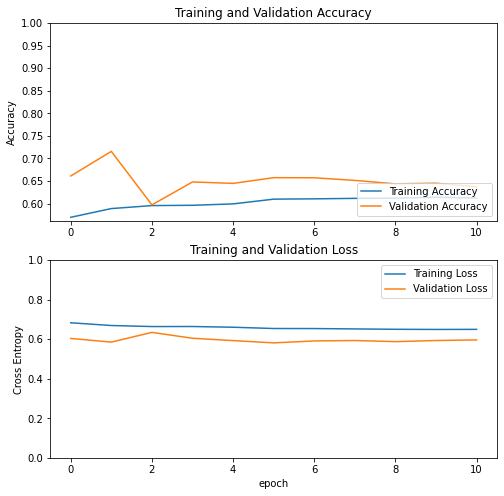

In [ ]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluating on test set. 

In [ ]:
loss, accuracy = model_resnet.evaluate(test_dataset)
print("loss: {:.4f}".format(loss))
print("accuracy: {:.4f}".format(accuracy))

40/40 [==============================] - 35s 864ms/step - loss: 0.5806 - accuracy: 0.6540
loss: 0.5806
accuracy: 0.6540


Extracting true label from tf_dataset and getting the probabilistic prediction for each image in the dataset (y_prob) and converting it into labels. 

In [ ]:
y_true = np.concatenate([label for _, label in test_dataset], axis=0)
Y_prob = model_resnet.predict(test_dataset)
y_pred = np.where(Y_prob < 0.5, 0, 1)  #if the probability for an image to be dank (aka to be classfied as 1) is less than 0.5 it will be labelled as 0.

### Reshaping for sklearn classification_report and for AUC plots
Y_prob = Y_prob.reshape(y_true.shape)
y_pred = y_pred.reshape(y_true.shape)


Accuracy, Recall, Precision, F1 score calculation for class 1 "manually". 
In the documentationm it is stated that the subfolders in train/valid/test sets are concatenated in alphabetical order. In addition, with the knowledge of having 240 dank cases we can also check that instances from index 4760 till and including index 4999 only contain dank memes label. This is the key when we can speprate them into TP, FP, TN, FN. 

In [ ]:
dank = dict()
not_dank = dict()

### collecting dank and not dank instances via its loop iteration value and probability into two, appropriate dictionaries.
for i, pred in enumerate(Y_prob): 
  if pred >= 0.5: 
    dank[i] = pred

  else: 
    not_dank[i] = pred


pred1_true0 = list() #False positive instances 
pred1_true1 = list() #True positive instances 
pred0_true0 = list() #True negative instances 
pred0_true1 = list() #False negative instances

for key in dank.keys(): 
  if key >= 4760: 
    pred1_true1.append(key)

  else: 
    pred1_true0.append(key)


for key in not_dank.keys(): 
  if key >= 4760: 
    pred0_true1.append(key)

  else: 
    pred0_true0.append(key)


accuracy = (len(pred1_true1) + len(pred0_true0)) / 5000
precision = len(pred1_true1) / (len(pred1_true1) + len(pred1_true0))
recall = len(pred1_true1) / (len(pred1_true1) + len(pred0_true1))
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')



Accuracy: 0.6540
Precision: 0.0815
Recall: 0.6042
F1-score: 0.1436


Using the built-in classification report from sklearn.

In [ ]:
target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           0     0.9705    0.6565    0.7832      4760
           1     0.0815    0.6042    0.1436       240

    accuracy                         0.6540      5000
   macro avg     0.5260    0.6303    0.4634      5000
weighted avg     0.9278    0.6540    0.7525      5000



Plotting the Precision-Recall Curve (the more relevant curve for imbalanced binary classification task) 

PR AUC: 0.09131112040158296


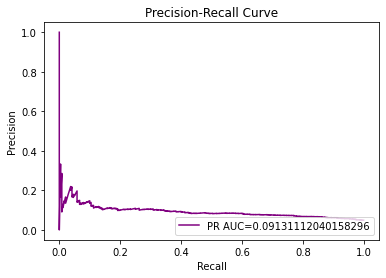

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true, Y_prob)
auc_precision_recall = auc(recall, precision)
print('PR AUC:', auc_precision_recall)

plt.plot(recall, precision, label="PR AUC="+str(auc_precision_recall), color = 'purple')
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc=4)
plt.show()


ROC AUC: 0.6804276085434173


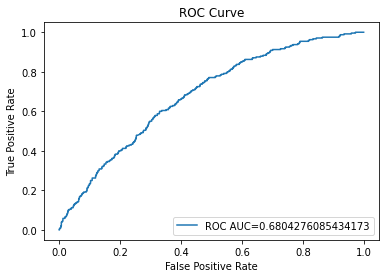

In [ ]:
fpr, tpr, _ = roc_curve(y_true,  Y_prob)
rocAUC_score = roc_auc_score(y_true, Y_prob)

print('ROC AUC:', rocAUC_score)

#create ROC curve
plt.plot(fpr,tpr,label="ROC AUC="+str(rocAUC_score))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Fine-Tuning

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  564


Keep the first 400 layers frozen, the rest will be unfrozen. The importance that we set training = false as one of the argument of base_model when creating our Neural Netwrok is even though some the last layers will be unfrozen but batchnorm layers will not update its batch stats. 

In [ ]:
fine_tune_at = 400
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

We chose a much lower initial learning rate  and RMSPROP as optimization method for fine-tuning

In [ ]:
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss = 'binary_crossentropy',
              weighted_metrics=['accuracy'],
              )

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='resnet_best_model_weights_w_ft.hdf5', save_best_only=True, verbose=1)
callbacks = [checkpointer, early_stopping, lr_reduc]

In [ ]:
fine_tune_epochs = 5

history_resnet_fine = model_resnet.fit(train_dataset,
                    epochs=fine_tune_epochs,
                    validation_data = validation_dataset,
                    class_weight = cw,
                    workers = 8,
                    use_multiprocessing = True,
                    callbacks = callbacks)

Epoch 1/5
1939/1939 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.5948
Epoch 00001: val_loss improved from inf to 0.50041, saving model to resnet_best_model_weights_w_ft.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1939/1939 [==============================] - 1776s 904ms/step - loss: 0.6686 - accuracy: 0.5948 - val_loss: 0.5004 - val_accuracy: 0.8934 - lr: 1.0000e-04
Epoch 2/5
1939/1939 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6141
Epoch 00002: val_loss did not improve from 0.50041
1939/1939 [==============================] - 1765s 906ms/step - loss: 0.6519 - accuracy: 0.6141 - val_loss: 0.5377 - val_accuracy: 0.8366 - lr: 1.0000e-04
Epoch 3/5
1939/1939 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.6231
Epoch 00003: val_loss improved from 0.50041 to 0.44863, saving model to resnet_best_model_weights_w_ft.hdf5
1939/1939 [==============================] - 1763s 906ms/step - loss: 0.6451 - accuracy: 0.6231 - val_loss: 0.4486 - val_accuracy: 0.9408 - lr: 1.0000e-04
Epoch 4/5
1939/1939 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.6279
Epoch 00004: val_loss improved from 0.44863 to 0.44239, saving model to resnet_best_m

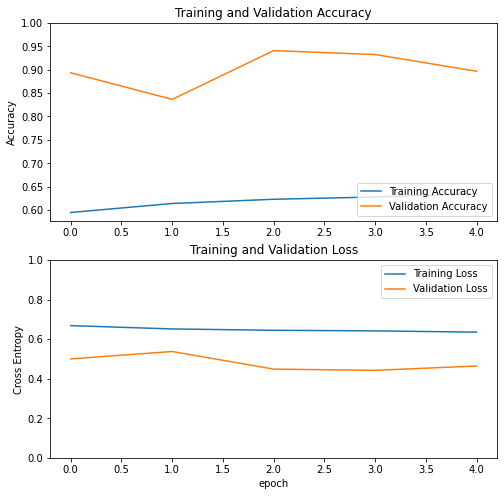

In [ ]:
acc = history_resnet_fine.history['accuracy']
val_acc = history_resnet_fine.history['val_accuracy']

loss = history_resnet_fine.history['loss']
val_loss = history_resnet_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model_resnet.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss))
print("Test accuracy: {:.4f}".format(accuracy))

40/40 [==============================] - 35s 855ms/step - loss: 0.4604 - accuracy: 0.8996
Test loss: 0.4604
Test accuracy: 0.8996


In [ ]:
Y_prob = model_resnet.predict(test_dataset)
y_pred = np.where(Y_prob < 0.5, 0, 1) 

Y_prob = Y_prob.reshape(y_true.shape)
y_pred = y_pred.reshape(y_true.shape)

In [ ]:
target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           0     0.9567    0.9370    0.9467      4760
           1     0.1124    0.1583    0.1315       240

    accuracy                         0.8996      5000
   macro avg     0.5345    0.5477    0.5391      5000
weighted avg     0.9161    0.8996    0.9076      5000



PR AUC: 0.08822884910791969


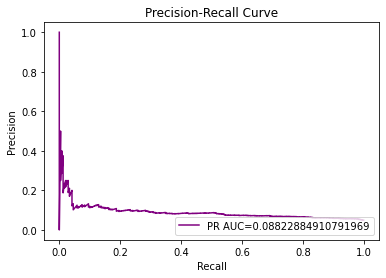

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true, Y_prob)
auc_precision_recall = auc(recall, precision)
print('PR AUC:', auc_precision_recall)

plt.plot(recall, precision, label="PR AUC="+str(auc_precision_recall), color = 'purple')
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc=4)
plt.show()


ROC AUC: 0.6635718662464987


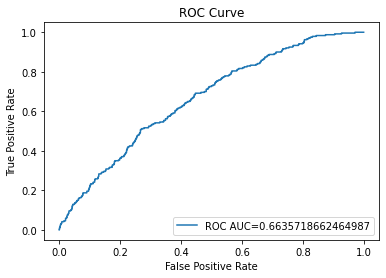

In [ ]:
fpr, tpr, _ = roc_curve(y_true,  Y_prob)
rocAUC_score = roc_auc_score(y_true, Y_prob)

print('ROC AUC:', rocAUC_score)

#create ROC curve
plt.plot(fpr,tpr,label="ROC AUC="+str(rocAUC_score))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Xception

In [ ]:
###Xception

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

### Using Functional API. With data augumentation incorporated here, gpu will be better deployed. Only augument on train_dataset
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False) # Running in inference mode. That will be important when unfreezing the base_model because batchnorm will not update its batnorm stats.
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_xcept = tf.keras.Model(inputs, outputs)


In [ ]:
base_learning_rate = 0.001
model_xcept.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = 'binary_crossentropy',
              weighted_metrics=['accuracy'],
              )

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

lr_reduc = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                            patience=3,
                            verbose=1,
                            factor=0.2,
                            min_lr=0.00001)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='xcept_best_model_weights_wo_ft.hdf5', save_best_only=True, verbose=1)

callbacks = [checkpointer, early_stopping, lr_reduc]


In [ ]:
cw={0: w0, 1: w1}
initial_epochs = 15

history_xcept = model_xcept.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset,
                    class_weight = cw,
                    workers = 8,
                    use_multiprocessing = True,
                    callbacks = callbacks)

Epoch 1/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.5752
Epoch 00001: val_loss improved from inf to 0.59297, saving model to xcept_best_model_weights_wo_ft.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1939/1939 [==============================] - 1730s 887ms/step - loss: 0.6774 - accuracy: 0.5752 - val_loss: 0.5930 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 2/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.5921
Epoch 00002: val_loss did not improve from 0.59297
1939/1939 [==============================] - 1688s 867ms/step - loss: 0.6688 - accuracy: 0.5921 - val_loss: 0.6056 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 3/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.5922
Epoch 00003: val_loss improved from 0.59297 to 0.58553, saving model to xcept_best_model_weights_wo_ft.hdf5
1939/1939 [==============================] - 1689s 867ms/step - loss: 0.6663 - accuracy: 0.5922 - val_loss: 0.5855 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 4/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.5975
Epoch 00004: val_loss improved from 0.58553 to 0.57470, saving model to xcept_best_model_weigh

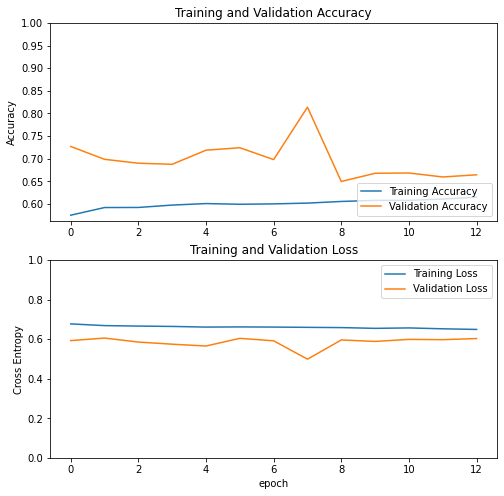

In [ ]:
acc = history_xcept.history['accuracy']
val_acc = history_xcept.history['val_accuracy']

loss = history_xcept.history['loss']
val_loss = history_xcept.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model_xcept.evaluate(test_dataset)
print("loss: {:.4f}".format(loss))
print("accuracy: {:.4f}".format(accuracy))

40/40 [==============================] - 34s 835ms/step - loss: 0.4967 - accuracy: 0.8092
loss: 0.4967
accuracy: 0.8092


In [ ]:
Y_prob = model_xcept.predict(test_dataset)
y_pred = np.where(Y_prob < 0.5, 0, 1) 

y_true = np.concatenate([label for _, label in test_dataset], axis=0)
Y_prob = Y_prob.reshape(y_true.shape)
y_pred = y_pred.reshape(y_true.shape)

In [ ]:
target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           0     0.9594    0.8349    0.8928      4760
           1     0.0839    0.3000    0.1311       240

    accuracy                         0.8092      5000
   macro avg     0.5217    0.5674    0.5120      5000
weighted avg     0.9174    0.8092    0.8563      5000



PR AUC: 0.0831678006003215


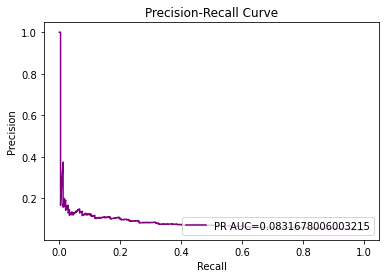

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true, Y_prob)
auc_precision_recall = auc(recall, precision)
print('PR AUC:', auc_precision_recall)

plt.plot(recall, precision, label="PR AUC="+str(auc_precision_recall), color = 'purple')
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc=4)
plt.show()


ROC AUC: 0.6223297443977591


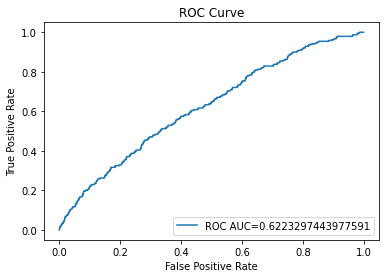

In [ ]:
fpr, tpr, _ = roc_curve(y_true,  Y_prob)
rocAUC_score = roc_auc_score(y_true, Y_prob)

print('ROC AUC:', rocAUC_score)

#create ROC curve
plt.plot(fpr,tpr,label="ROC AUC="+str(rocAUC_score))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
!cp "./xcept_best_model_weights_wo_ft.hdf5" "/content/gdrive/MyDrive/dl_reddit/"
!cp "./resnet_best_model_weights_wo_ft.hdf5"  "/content/gdrive/MyDrive/dl_reddit/"
!cp "./resnet_best_model_weights_w_ft.hdf5"  "/content/gdrive/MyDrive/dl_reddit/"